In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import jaxttv, elements_to_pdic, params_to_elements
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

In [4]:
dt = 0.5 * 2
t_start, t_end = 155., 1495 + 1455
jttv = jaxttv(t_start, t_end, dt)

In [5]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)


initial objective function: 5448.24 (53 data)

running LM optimization...
objective function: 46.17 (53 data)
# elapsed time (least square): 2.9 sec


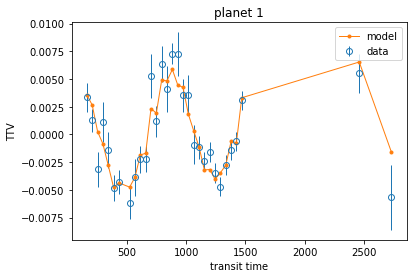

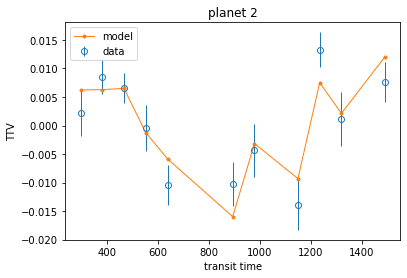

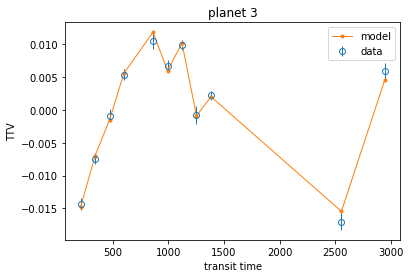

In [6]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.1)

In [10]:
tc, de = jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))
print (de)

-4.972765113353539e-06


In [11]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

4.96 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

      pmass      period     ecosw     esinw  cosi  lnode         tic  \
0  2.362789   45.153421 -0.017523 -0.044453  -0.0   -0.0  159.110433   
1  4.080329   85.313628  0.004990 -0.018216  -0.0   -0.0  295.319667   
2  5.220634  130.184146  0.000418 -0.014557  -0.0    0.0  212.023570   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.047782 -1.946280 -11.855893  0.000007 -0.366722 -0.930331  
1  0.018887 -1.303425 -11.309558  0.000012  0.264198 -0.964469  
2  0.014563 -1.542073 -11.063117  0.000016  0.028719 -0.999588  


In [14]:
pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(p_init)
ones = jnp.ones_like(p_guess)
pdic_init

{'period': DeviceArray([ 45.15342068,  85.31362777, 130.18414599], dtype=float64),
 'cosi': DeviceArray([-0., -0., -0.], dtype=float64),
 'lnode': DeviceArray([-0., -0.,  0.], dtype=float64),
 'tic': DeviceArray([159.11043286, 295.31966714, 212.02357023], dtype=float64),
 'ecc': DeviceArray([0.04778151, 0.01888699, 0.01456318], dtype=float64),
 'lnmass': DeviceArray([-11.85589308, -11.30955833, -11.06311706], dtype=float64),
 'mass': DeviceArray([7.09661193e-06, 1.22552232e-05, 1.56801174e-05], dtype=float64),
 'cosw': DeviceArray([-0.36672218,  0.26419755,  0.02871938], dtype=float64),
 'sinw': DeviceArray([-0.9303305 , -0.96446859, -0.99958751], dtype=float64)}

In [15]:
from numpyro.infer import init_to_value
import numpyro
import numpyro.distributions as dist
import jax.random as random
def model(dp=5e-1, dtic=1e-1, emax=0.5, mmin=1e-7, mmax=1e-3, uniform_mass=False):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))

    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = jnp.arctan2(sinw, cosw)
    numpyro.deterministic("omega", omega)

    #cosO = numpyro.sample("cosO", dist.Normal(scale=jnp.array([1, 1])))
    #sinO = numpyro.sample("sinO", dist.Normal(scale=jnp.array([1, 1])))
    #lnode = jnp.arctan2(sinO, cosO)
    lnode = ones * 0
    numpyro.deterministic("lnode", lnode)
    cosi = ones * 0
    numpyro.deterministic("cosi", cosi)
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.exp(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    elements = jnp.array([period, ecc*cosw, ecc*sinw, cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    #tcmodel, ediff = jttv.get_ttvs_hermite4(elements, jnp.hstack([1, mass]))
    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    #tcmodel = jnp.nan_to_num(tcmodel, nan=-jnp.inf)
    #ediff = jnp.nan_to_num(ediff, nan=jnp.inf)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=jttv.errorobs_flatten), obs=jttv.tcobs_flatten)

In [16]:
init_strategy = init_to_value(values=pdic_init)
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)

In [17]:
nw, ns = 100, 100  # dt=1, all data, 1.5hr
nw, ns = 500, 1500 

In [18]:
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)

In [ ]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, mmin=0, mmax=1e-4, uniform_mass=True)

warmup:  18%|███████▉                                   | 367/2000 [2:51:29<10:27:10, 23.04s/it, 563 steps of size 4.18e-03. acc. prob=0.88]

In [ ]:
base = "kep51/linmass_dt%.1f_nw%d_ns%d_"%(dt, nw, ns)

In [ ]:
mcmc.print_summary()

In [ ]:
import dill
with open(base+"mcmc.pkl", "wb") as f:
    dill.dump(mcmc, f)

In [ ]:
samples = mcmc.get_samples()

In [ ]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel, save=base+"postm")

In [ ]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']
#keys = ['lnmass', 'tic', 'period', 'ecc', 'omega']

In [ ]:
plt.hist(np.log10(np.abs(samples['ediff'])))

In [ ]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    fig = corner.corner(hyper, labels=keys, show_titles="%.2f")
    plt.savefig(base+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight")

### check convergence

In [ ]:
jttv2 = jaxttv(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

In [ ]:
k = 500

In [ ]:
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))

In [ ]:
#%%
samples['ediff'][k], ediff1

#%%
plt.ylabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.)